# Projeto Análise de Vendas 

#### Imports e base de dados

In [748]:
    # imports para analise e visualização
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np

    # modelos
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [750]:
url = 'https://raw.githubusercontent.com/Seunfunmee/Retail-Sales-Data-Set/refs/heads/main/Retail%20Sales%20Data%20Set.csv'
df = pd.read_csv(url)
df.head(3)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Min_age,Max_age,Avg_age,Total Sales Revenue,Average Order value,Category,Sales
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,NaN,...,NaN,NaN,NaN,18.0,64.0,41.0,456000.0,456.0,Electronics,156905.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clothing,155580.0
2,3,1/13/2023,Male,50,Middle Age,Electronics,1,30,30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beauty,143515.0


## Análise exploratória

In [754]:
# as colunas Unnamed de 9 a 16 são espaços para melhorar a vizualizão quando na planilha, para essa análise elas serão dropadas
# drop das colunas não usadas

colunas_removidas = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
                    'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']
df = df.drop(columns = colunas_removidas) 
df.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Min_age,Max_age,Avg_age,Total Sales Revenue,Average Order value,Category,Sales
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,18.0,64.0,41.0,456000.0,456.0,Electronics,156905.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN,NaN,NaN,NaN,NaN,Clothing,155580.0


In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Transaction ID       1000 non-null   int64  
 1   Date                 1000 non-null   object 
 2   Gender               1000 non-null   object 
 3   Age                  1000 non-null   int64  
 4   Age Group            1000 non-null   object 
 5   Product Category     1000 non-null   object 
 6   Quantity             1000 non-null   int64  
 7   Price per Unit       1000 non-null   int64  
 8   Total Amount         1000 non-null   int64  
 9   Min_age              1 non-null      float64
 10  Max_age              1 non-null      float64
 11  Avg_age              1 non-null      float64
 12  Total Sales Revenue  1 non-null      float64
 13  Average Order value  1 non-null      float64
 14   Category            3 non-null      object 
 15  Sales                3 non-null      fl

In [758]:
# drop das colunas min_age, mas_age e Avg_age por guardarem somente o valor minimo, maximo e a media das idades 

colunas_removidas = ['Min_age', 'Max_age', 'Avg_age']
df = df.drop(columns = colunas_removidas) 
df.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Total Sales Revenue,Average Order value,Category,Sales
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,456000.0,456.0,Electronics,156905.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN,NaN,Clothing,155580.0


In [760]:
# entendendo coluna Total Sales Revenue
# se trata do valor total vendido, ou seja o valor vendido em toda a base
igual_total_sale_revenue = df['Total Amount'].sum()
igual_total_sale_revenue

456000

In [762]:
# removendo Total Sales Revenue e category, category só armazena as categorias possiveis na base
# como a coluna Sales armazena somente o velor total vendido por categoria não usarei ela

colunas_usadas = ['Transaction ID', 'Date', 'Gender', 'Age', 'Age Group', 'Product Category', 'Quantity', 'Price per Unit',
                     'Total Amount', 'Average Order value']
df_vendas = df[colunas_usadas]
df_vendas.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Average Order value
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,456.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN


In [764]:
# analisando se houveram clientes que fizeram mais de uma compra
# como o df só tem 1000 registros (linhas) e a soma deu 1000 isso siguinifica que cada cliente só fez uma compra
# ou seja o valor da coluna Average Order value não armazena a media do peido

mais_de_uma_compra = df_vendas['Transaction ID'].value_counts()
mais_de_uma_compra.sum()

1000

In [766]:
# talvez a coluna Average Order value seja media por categoria?

grupo_catg = df_vendas.groupby('Product Category').agg(
    Total_Amount=pd.NamedAgg(column='Total Amount', aggfunc='mean')
).reset_index().round(2)
grupo_catg

,Product Category,Total_Amount
0,Beauty,467.48
1,Clothing,443.25
2,Electronics,458.79


In [768]:
# talvez a coluna Average Order value seja media por grupo de idade?

grupo_idade = df_vendas.groupby('Age Group').agg(
    Total_Amount=pd.NamedAgg(column='Total Amount', aggfunc='mean')
).reset_index().round(2)
grupo_idade

,Age Group,Total_Amount
0,Adolescent,485.31
1,Middle Age,455.31
2,Old,417.55


In [770]:
# Devido a falta de informações e relevancia da coluna Average Order value ela sera descontinuada na analise

df_vendas = df_vendas.drop(columns = ['Average Order value'])
df_vendas.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000


In [772]:
# qual a categoria de produtos com mais lucro?
# pouca diferença entre as categorias

melhor_categ = df_vendas.groupby('Product Category').agg(
    lucro = pd.NamedAgg(column='Total Amount', aggfunc='sum')
).reset_index()

melhor_categ

,Product Category,lucro
0,Beauty,143515
1,Clothing,155580
2,Electronics,156905


In [774]:
# qual o grupo de idades que mais gastam?

melhor_group_age = df_vendas.groupby('Age Group').agg(
    vendas = pd.NamedAgg(column='Total Amount',aggfunc='sum')
).reset_index()

# criando coluna porcem que guarda a porcentagem das vendas em relação ao valor total
melhor_group_age['porcem'] = (melhor_group_age['vendas'] / total_vendas) *100 

melhor_group_age.round(2)

,Age Group,vendas,porcem
0,Adolescent,143165,31.40
1,Middle Age,222645,48.83
2,Old,90190,19.78


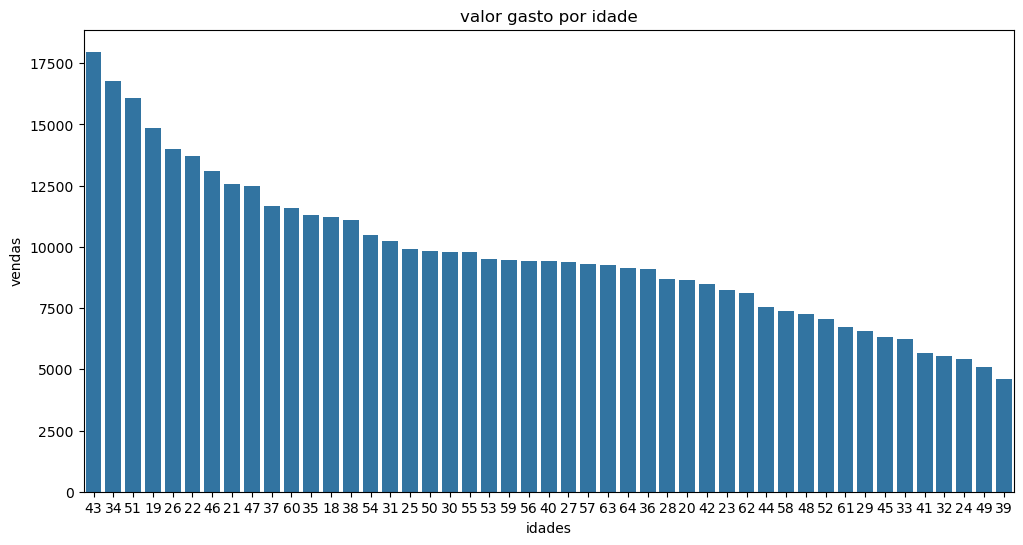

In [776]:
# qual a idade que mais gastam?

melhor_age = df_vendas.groupby('Age').agg(
    vendas = pd.NamedAgg(column='Total Amount',aggfunc='sum')
).reset_index()

# criando grafico de lihas para melhor visualização
plt.figure(figsize=(12,6))
sns.barplot(x='Age', y='vendas', data=melhor_age, 
            order=melhor_age.sort_values('vendas', ascending=False)['Age'])

plt.title('valor gasto por idade')
plt.xlabel('idades')
plt.ylabel('vendas')

plt.show()

In [777]:
# removendo janeiro de 2024 e dezembro de 2022, o foco das analises são no ano de 2023

# Garantir que a coluna 'Date' seja do tipo datetime
df_vendas['Date'] = pd.to_datetime(df_vendas['Date'])

# Selecionar apenas os dados de 2023
df_vendas = df_vendas[df_vendas['Date'].dt.year == 2023]
# criando novo df com agrupamento do valor por semana

grupo_semana = df_vendas.groupby(df_vendas['Date'].dt.to_period('W').dt.to_timestamp()).agg(
    Total_Amount=pd.NamedAgg(column='Total Amount', aggfunc='sum')
).reset_index()

# Ver as primeiras linhas do novo DataFrame
grupo_semana.head()

,Date,Total_Amount
0,2022-12-26,3600
1,2023-01-02,6100
2,2023-01-09,4850
3,2023-01-16,8215
4,2023-01-23,9845


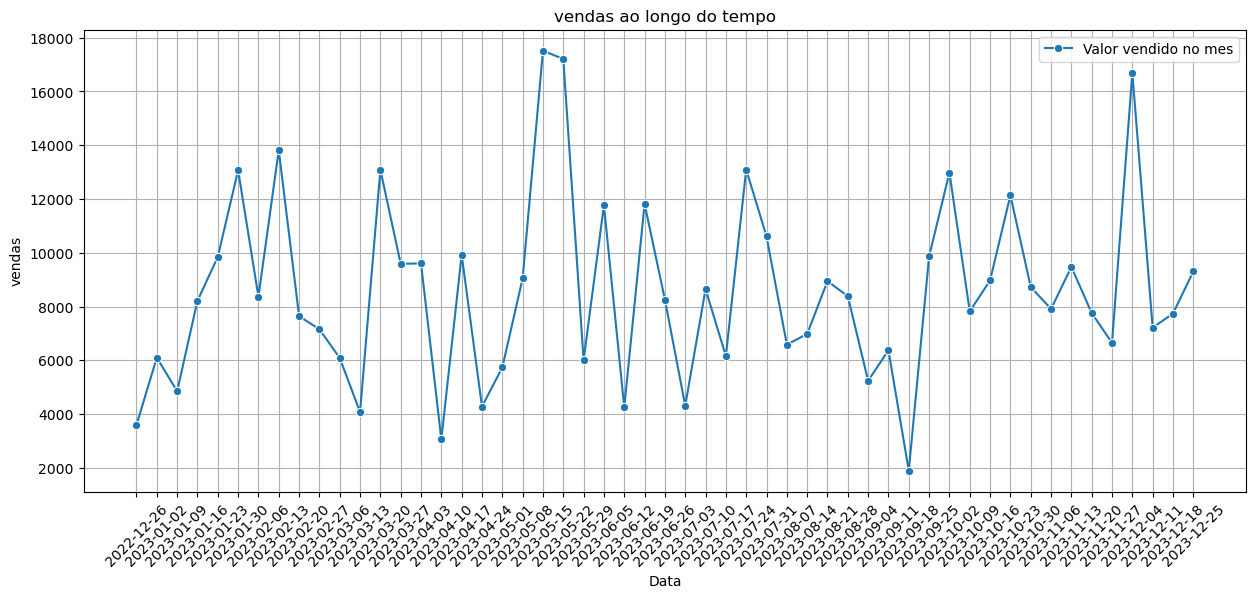

In [778]:
# Converter 'Date' para string para evitar erros no gráfico
grupo_semana['Date'] = grupo_semana['Date'].astype(str)

# criando grafico de linhas 

plt.figure(figsize=(15,6))
sns.lineplot(x='Date', y='Total_Amount', data=grupo_semana, marker='o', label='Valor vendido no mes')

plt.xlabel('Data')
plt.ylabel('vendas')
plt.title('vendas ao longo do tempo')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

plt.show()

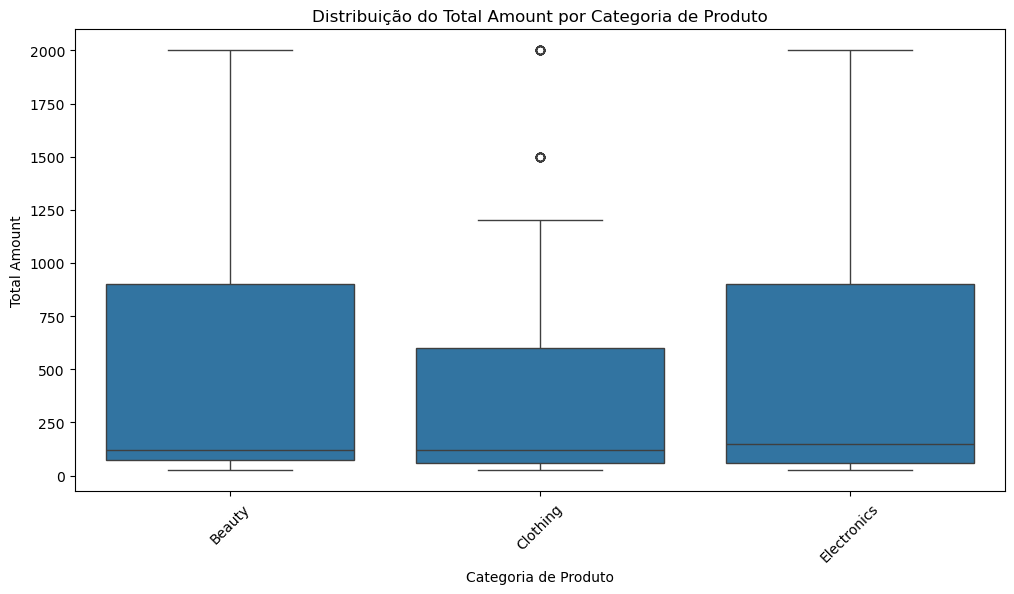

In [779]:
# Criando grafico boxplot

plt.figure(figsize=(12, 6))
sns.boxplot(x='Product Category', y='Total Amount', data=df_vendas)

plt.title('Distribuição do Total Amount por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('Total Amount')

plt.xticks(rotation=45)  
plt.show()

In [782]:
# Filtrando o DataFrame para a categoria 'Clothing'
df_clothing = df_vendas[df_vendas['Product Category'] == 'Clothing']

# Calculando os quartis e o IQR para 'Total Amount' apenas para Clothing
Q1_clothing = df_clothing['Total Amount'].quantile(0.25)
Q3_clothing = df_clothing['Total Amount'].quantile(0.75)
IQR_clothing = Q3_clothing - Q1_clothing

# Definindo os limites para outliers na categoria Clothing
limite_inferior_clothing = Q1_clothing - 1.5 * IQR_clothing
limite_superior_clothing = Q3_clothing + 1.5 * IQR_clothing

# Filtrando os outliers para a categoria Clothing
outliers_clothing = df_clothing[(df_clothing['Total Amount'] < limite_inferior_clothing) | 
                                (df_clothing['Total Amount'] > limite_superior_clothing)]
print("Outliers na categoria Clothing:")
outliers_clothing.head()

Outliers na categoria Clothing:


,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount
15,16,2023-02-17,Male,19,Adolescent,Clothing,3,500,1500
77,78,2023-07-01,Female,47,Middle Age,Clothing,3,500,1500
111,112,2023-12-02,Male,37,Middle Age,Clothing,3,500,1500
114,115,2023-11-26,Male,51,Middle Age,Clothing,3,500,1500
123,124,2023-10-27,Male,33,Middle Age,Clothing,4,500,2000


não vejo motivo para remover essas linhas, então vou manter elas no df

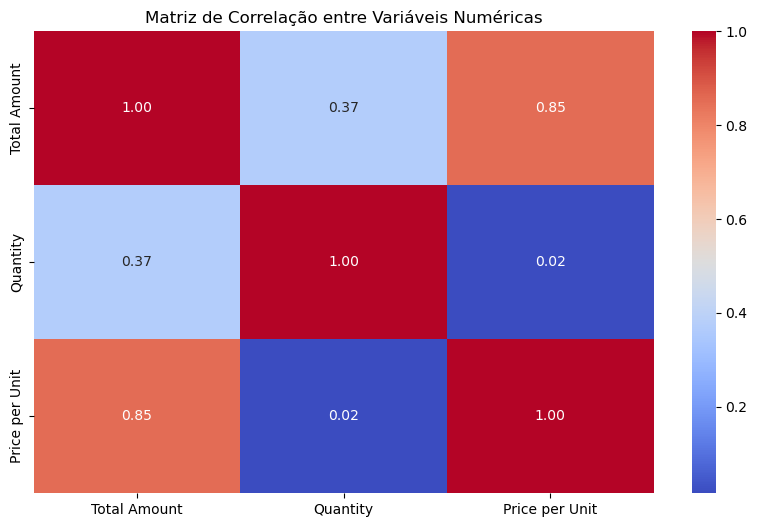

In [784]:
# separando colunas numericas
colunas_numericas = ['Total Amount', 'Quantity', 'Price per Unit']
df_numerico = df_vendas[colunas_numericas]

# calculando a matriz de correlação
correlacao = df_numerico.corr()

# plot matriz de correlação
plt.figure(figsize=(10,6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

todas tem uma correlação boa, tirando quantidade mas ela é importante sim

## Modelo ARIMA

Escolhi o ARIMA devido à sua capacidade de modelar séries temporais, capturando tendências e sazonalidades, ideal para prever vendas futuras com base em dados históricos.

In [792]:
# vendo tipos dos dados

df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    998 non-null    int64         
 1   Date              998 non-null    datetime64[ns]
 2   Gender            998 non-null    object        
 3   Age               998 non-null    int64         
 4   Age Group         998 non-null    object        
 5   Product Category  998 non-null    object        
 6   Quantity          998 non-null    int64         
 7   Price per Unit    998 non-null    int64         
 8   Total Amount      998 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 78.0+ KB


preparando a base pro ARIMA

In [795]:
# drop de duplicatas
df_vendas = df_vendas.drop_duplicates(subset='Date')
# Definindo 'Date' como índice
df_vendas.set_index('Date', inplace=True)
df_vendas.head(3)

,Transaction ID,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount
Date,,,,,,,,
2023-11-24,1,Male,34,Middle Age,Beauty,3,50,150
2023-02-27,2,Female,26,Adolescent,Clothing,2,500,1000
2023-01-13,3,Male,50,Middle Age,Electronics,1,30,30


In [797]:
# Ordenando os dados por data
df_vendas = df_vendas.sort_index()
df_vendas.head()

,Transaction ID,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount
Date,,,,,,,,
2023-01-01,180,Male,41,Middle Age,Clothing,3,300,900
2023-01-02,163,Female,64,Old,Clothing,3,50,150
2023-01-03,610,Female,26,Adolescent,Beauty,2,300,600
2023-01-04,32,Male,30,Adolescent,Beauty,3,30,90
2023-01-05,367,Female,57,Old,Electronics,1,50,50


In [799]:
# vendo se a base é estacionaria  / se o valor for menos que 0.05 ela é estacionaria
# Realizando o teste ADF

result = adfuller(df_vendas['Total Amount'])
print(f"Valor p do teste ADF: {result[1]}")


Valor p do teste ADF: 3.5679441580313984e-30


In [801]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2023-01-01 to 2023-12-31
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    344 non-null    int64 
 1   Gender            344 non-null    object
 2   Age               344 non-null    int64 
 3   Age Group         344 non-null    object
 4   Product Category  344 non-null    object
 5   Quantity          344 non-null    int64 
 6   Price per Unit    344 non-null    int64 
 7   Total Amount      344 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 24.2+ KB


In [803]:
# Ajustando para frequência semanal
df_vendas = df_vendas.asfreq('W')

# Definindo os dados de treino e teste (80% para treino e 20% para teste)
treino = df_vendas['Total Amount'][:int(len(df_vendas)*0.8)]
teste = df_vendas['Total Amount'][int(len(df_vendas)*0.8):]

# Ajustando o modelo ARIMA para os dados de treino
modelo = ARIMA(treino, order=(1, 0, 1))  # Exemplo com p=1, d=0, q=1
modelo_fit = modelo.fit()

# Previsões para o conjunto de teste
previsoes = modelo_fit.forecast(steps=len(teste))

# Exibindo as previsões
print(previsoes)

# Se desejar prever mais passos (12 semanas no exemplo), pode fazer:
previsoes_futuras = modelo_fit.forecast(steps=12)  # Previsões para as próximas 12 semanas


2023-10-22    475.199940
2023-10-29    466.944706
2023-11-05    461.537148
2023-11-12    457.994950
2023-11-19    455.674648
2023-11-26    454.154744
2023-12-03    453.159137
2023-12-10    452.506968
2023-12-17    452.079768
2023-12-24    451.799933
2023-12-31    451.616627
Freq: W-SUN, Name: predicted_mean, dtype: float64


In [805]:
# Calcular MAE, RMSE e MAPE
mae = mean_absolute_error(teste, previsoes)
rmse = np.sqrt(mean_squared_error(teste, previsoes))
mape = np.mean(np.abs((teste - previsoes) / teste)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 463.31978947816407
RMSE: 518.5422797830663
